In [49]:
import py3Dmol
import time
import json
import requests
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

UNIPROT_ACCESSION = "P00533"
SPECIES_TAXID = 9606 # homosapiens
UNIPROT_BASE = "https://rest.uniprot.org/uniprotkb"
STRING_CALLER_IDENTITY = "email@email.com"


In [ ]:
# ============================================================
# Step 1 — Retrieve core data from UniProt
# ============================================================

def fetch_uniprot_entry(accession: str) -> dict:
    """
    Fetch full UniProtKB JSON for a single accession.
    """
    url = f"{UNIPROT_BASE}/{accession}"
    params = {"format": "json"}
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()


def extract_basic_info(entry: dict):
    """
    Extract sequence length, gene symbol, PTMs (free-text), diseases,
    PDB IDs, STRING ID from UniProt JSON.
    """
    seq_length = entry.get("sequence", {}).get("length")

    genes = entry.get("genes", [])
    if genes and "geneName" in genes[0]:
        gene_symbol = genes[0]["geneName"]["value"]
    else:
        gene_symbol = entry.get("uniProtkbId", UNIPROT_ACCESSION)

    ptm_texts = []
    disease_info = []

    for c in entry.get("comments", []):
        ctype = c.get("commentType")
        if ctype == "PTM":
            for t in c.get("texts", []):
                if "value" in t:
                    ptm_texts.append(t["value"])
        elif ctype == "DISEASE":
            d = c.get("disease", {})
            disease_name = d.get("diseaseId", d.get("diseaseAccession", ""))
            description = d.get("description", "")
            disease_info.append({
                "name": disease_name,
                "acronym": d.get("acronym", ""),
                "description": description
            })

    pdb_ids = set()
    string_ids = set()

    for xref in entry.get("uniProtKBCrossReferences", []):
        db = xref.get("database")
        xid = xref.get("id")
        if db == "PDB" and xid:
            pdb_ids.add(xid)
        elif db == "STRING" and xid:
            string_ids.add(xid)

    string_id = next(iter(string_ids)) if string_ids else None

    return {
        "seq_length": seq_length,
        "gene_symbol": gene_symbol,
        "ptm_texts": ptm_texts,
        "disease_info": disease_info,
        "pdb_ids": sorted(pdb_ids),
        "string_id": string_id,
    }



entry = fetch_uniprot_entry(UNIPROT_ACCESSION)
core_info = extract_basic_info(entry)

print("=== UniProt core data ===")
print(f"Protein: {UNIPROT_ACCESSION}")
print(f"Gene symbol: {core_info['gene_symbol']}")
print(f"Sequence length: {core_info['seq_length']} aa")
print(f"Number of PDB structures (cross-refs): {len(core_info['pdb_ids'])}")
print(f"Total PDB IDs: {len(core_info['pdb_ids'])}")
print(f"Example PDB IDs: {core_info['pdb_ids'][:10]}")
print(f"STRING ID: {core_info['string_id']}")

print("\nPost-translational modification comments (PTM):")
for t in core_info["ptm_texts"]:
    print(" -", t)

print("\nDisease associations:")
for d in core_info["disease_info"]:
    print(f" - {d['name']}: {d['description']}")


=== UniProt core data ===
Protein: P00533
Gene symbol: EGFR
Sequence length: 1210 aa
Number of PDB structures (cross-refs): 334
Total PDB IDs: 334
Example PDB IDs: ['1IVO', '1M14', '1M17', '1MOX', '1NQL', '1XKK', '1YY9', '1Z9I', '2EB2', '2EB3']
STRING ID: 9606.ENSP00000275493

Post-translational modification comments (PTM):
 - Phosphorylated on Tyr residues in response to EGF (PubMed:20462955, PubMed:27153536). Phosphorylation at Ser-695 is partial and occurs only if Thr-693 is phosphorylated. Phosphorylation at Thr-678 and Thr-693 by PRKD1 inhibits EGF-induced MAPK8/JNK1 activation. Dephosphorylation by PTPRJ prevents endocytosis and stabilizes the receptor at the plasma membrane. Autophosphorylation at Tyr-1197 is stimulated by methylation at Arg-1199 and enhances interaction with PTPN6. Autophosphorylation at Tyr-1092 and/or Tyr-1110 recruits STAT3. Dephosphorylated by PTPN1 and PTPN2
 - Monoubiquitinated and polyubiquitinated upon EGF stimulation; which does not affect tyrosine kin

In [ ]:
# ============================================================
# Step 2 — Select one PDB structure and visualize it
# ============================================================


pdb_id = core_info['pdb_ids'][0]
print(f"\nUsing PDB ID: {pdb_id}")
pdb_file = f"{pdb_id}.pdb"
pdb_path = os.path.join(os.getcwd(), pdb_file)

if not os.path.exists(pdb_path):
    print(f"Downloading {pdb_id}.pdb from RCSB...")
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(pdb_path, 'w') as f:
            f.write(response.text)
        print(f"Successfully downloaded {pdb_file}")
    else:
        print(f"Failed to download {pdb_id}.pdb")
else:
    print(f"{pdb_file} already exists, using local file")

view = py3Dmol.view()
view.addModel(open(pdb_path, 'r').read(),'pdb')
view.setBackgroundColor('white')
view.setStyle({'chain':'A'}, {'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()



Using PDB ID: 1IVO
1IVO.pdb already exists, using local file


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Building interaction network for EGFR...
Starting BFS from EGFR for 2 hops...
  Hop 1: Processing 1 nodes...
  Hop 2: Processing 10 nodes...

Graph constructed:
  Nodes: 63
  Edges: 92
  Density: 0.0471


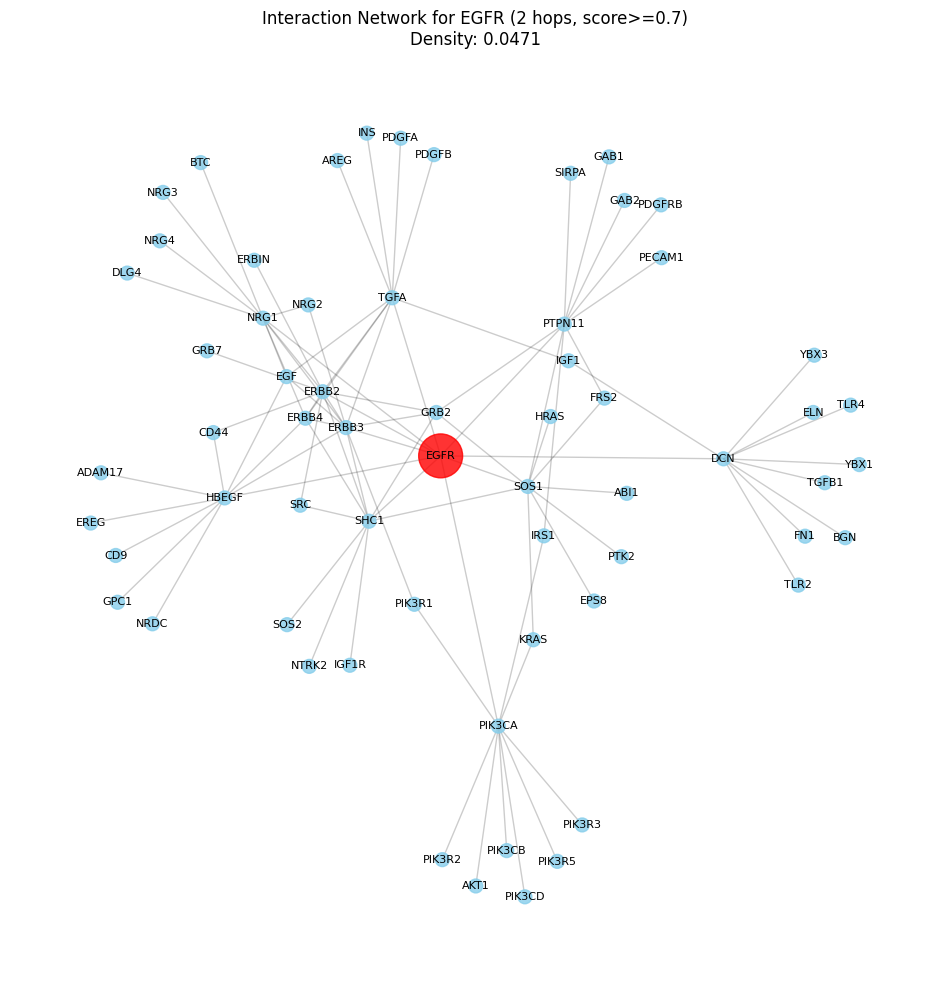

In [52]:
# ============================================================
# Step 3 — Build a STRING-based interaction network
# ============================================================

def string_first_neighbors(protein, species=9606, min_score=0.7):
    """
    Retrieve first neighbors of a protein using STRING interactors API.
    Returns list of (protein1, protein2, score)
    """

    url = f"https://string-db.org/api/json/interaction_partners?identifier={protein}&species={species}"
    
    try:
        response = requests.get(url)
        if not response.ok:
            print(f"Error fetching data: {response.status_code}")
            return []
            
        data = response.json()
        
        edges = []
        for e in data:
            score = e.get("score", 0)
            if score >= min_score:
                edges.append((protein, e["preferredName_B"], score))
                
        return edges
    except Exception as e:
        print(f"Exception: {e}")
        return []

def string_n_hop_neighbors(protein, n=2, species=9606, min_score=0.7):
    """
    Retrieve nodes and edges up to n hops away using BFS.
    """
    frontier = {protein}
    visited = {protein}
    all_edges = []
    
    print(f"Starting BFS from {protein} for {n} hops...")
    
    for hop in range(n):
        new_frontier = set()
        print(f"  Hop {hop+1}: Processing {len(frontier)} nodes...")
        
        for p in frontier:
            edges = string_first_neighbors(p, species=species, min_score=min_score)
            for p1, p2, score in edges:
                all_edges.append((p1, p2, score))
                
                if p2 not in visited:
                    visited.add(p2)
                    new_frontier.add(p2)
        
        frontier = new_frontier
        if not frontier:
            break
            
    return all_edges

gene_symbol = core_info['gene_symbol']
print(f"Building interaction network for {gene_symbol}...")

min_score = 0.7 

edges = string_n_hop_neighbors(gene_symbol, n=2, species=SPECIES_TAXID, min_score=min_score)

G = nx.Graph()
for p1, p2, score in edges:
    G.add_edge(p1, p2, weight=score)

print(f"\nGraph constructed:")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")

density = nx.density(G)
print(f"  Density: {density:.4f}")


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

node_colors = ['red' if n == gene_symbol else 'skyblue' for n in G.nodes()]
node_sizes = [1000 if n == gene_symbol else 100 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title(f"Interaction Network for {gene_symbol} (2 hops, score>={min_score})\nDensity: {density:.4f}")
plt.axis('off')
plt.show()

# I am not calling and displaying edges between nodes with distance >1 from gene_symbol

In [53]:
# ============================================================
# Step 4 — Compute graph centralities
# ============================================================

degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)

df_cent = pd.DataFrame({
    'Degree': degree_cent,
    'Betweenness': betweenness_cent,
    'Closeness': closeness_cent
})

def print_highlighted_top_10(df, metric, target):
    print(f"\nTop 10 Nodes by {metric} Centrality:")
    top_10 = df.sort_values(metric, ascending=False).head(10)

    print(f"{'Gene':<15} {metric}")
    print("-" * 25)
    for gene, row in top_10.iterrows():
        val = row[metric]
        line = f"{gene:<15} {val:.4f}"
        if gene == target:
            print(f"\033[1;31m{line}\033[0m")
        else:
            print(line)

print_highlighted_top_10(df_cent, 'Degree', gene_symbol)
print_highlighted_top_10(df_cent, 'Betweenness', gene_symbol)
print_highlighted_top_10(df_cent, 'Closeness', gene_symbol)

if gene_symbol in df_cent.index:
    print(f"\n--- Rankings for {gene_symbol} ---")
    for metric in ['Degree', 'Betweenness', 'Closeness']:
        sorted_df = df_cent.sort_values(metric, ascending=False)
        rank = sorted_df.index.get_loc(gene_symbol) + 1
        val = df_cent.loc[gene_symbol, metric]
        print(f"{metric}: Value={val:.4f}, Rank={rank}/{len(df_cent)}")
else:
    print(f"\n{gene_symbol} not found in the graph.")


Top 10 Nodes by Degree Centrality:
Gene            Degree
-------------------------
ERBB2           0.1774
ERBB3           0.1774
EGFR            0.1613
PTPN11          0.1613
HBEGF           0.1613
NRG1            0.1613
TGFA            0.1613
DCN             0.1613
SHC1            0.1613
SOS1            0.1613

Top 10 Nodes by Betweenness Centrality:
Gene            Betweenness
-------------------------
EGFR            0.5569
DCN             0.2506
PIK3CA          0.2107
PTPN11          0.1843
HBEGF           0.1693
SOS1            0.1655
TGFA            0.1512
NRG1            0.1393
SHC1            0.1233
ERBB2           0.1146

Top 10 Nodes by Closeness Centrality:
Gene            Closeness
-------------------------
EGFR            0.5439
ERBB3           0.4460
ERBB2           0.4306
SHC1            0.4189
SOS1            0.4189
TGFA            0.4079
PTPN11          0.4052
NRG1            0.4052
HBEGF           0.4000
DCN             0.3949

--- Rankings for EGFR ---
Degree: Valu

Simulating knockout of EGFR...
Before: Components=1, Diameter (largest comp)=4
After:  Components=1, Diameter (largest comp)=7

--- Centrality Changes (Top 10 by Degree before KO) ---
          Degree  Degree_KO    Change
ERBB2   0.177419   0.163934 -0.013485
ERBB3   0.177419   0.163934 -0.013485
PTPN11  0.161290   0.147541 -0.013749
HBEGF   0.161290   0.147541 -0.013749
NRG1    0.161290   0.147541 -0.013749
TGFA    0.161290   0.147541 -0.013749
DCN     0.161290   0.147541 -0.013749
SHC1    0.161290   0.147541 -0.013749
SOS1    0.161290   0.147541 -0.013749
PIK3CA  0.161290   0.147541 -0.013749

Top 5 New Hubs (Degree) After Knockout:
        Degree_KO  Betweenness_KO  Closeness_KO
ERBB2    0.163934        0.205303      0.383648
ERBB3    0.163934        0.376760      0.414966
PTPN11   0.147541        0.186292      0.311224
HBEGF    0.147541        0.162067      0.316062
NRG1     0.147541        0.130419      0.319372


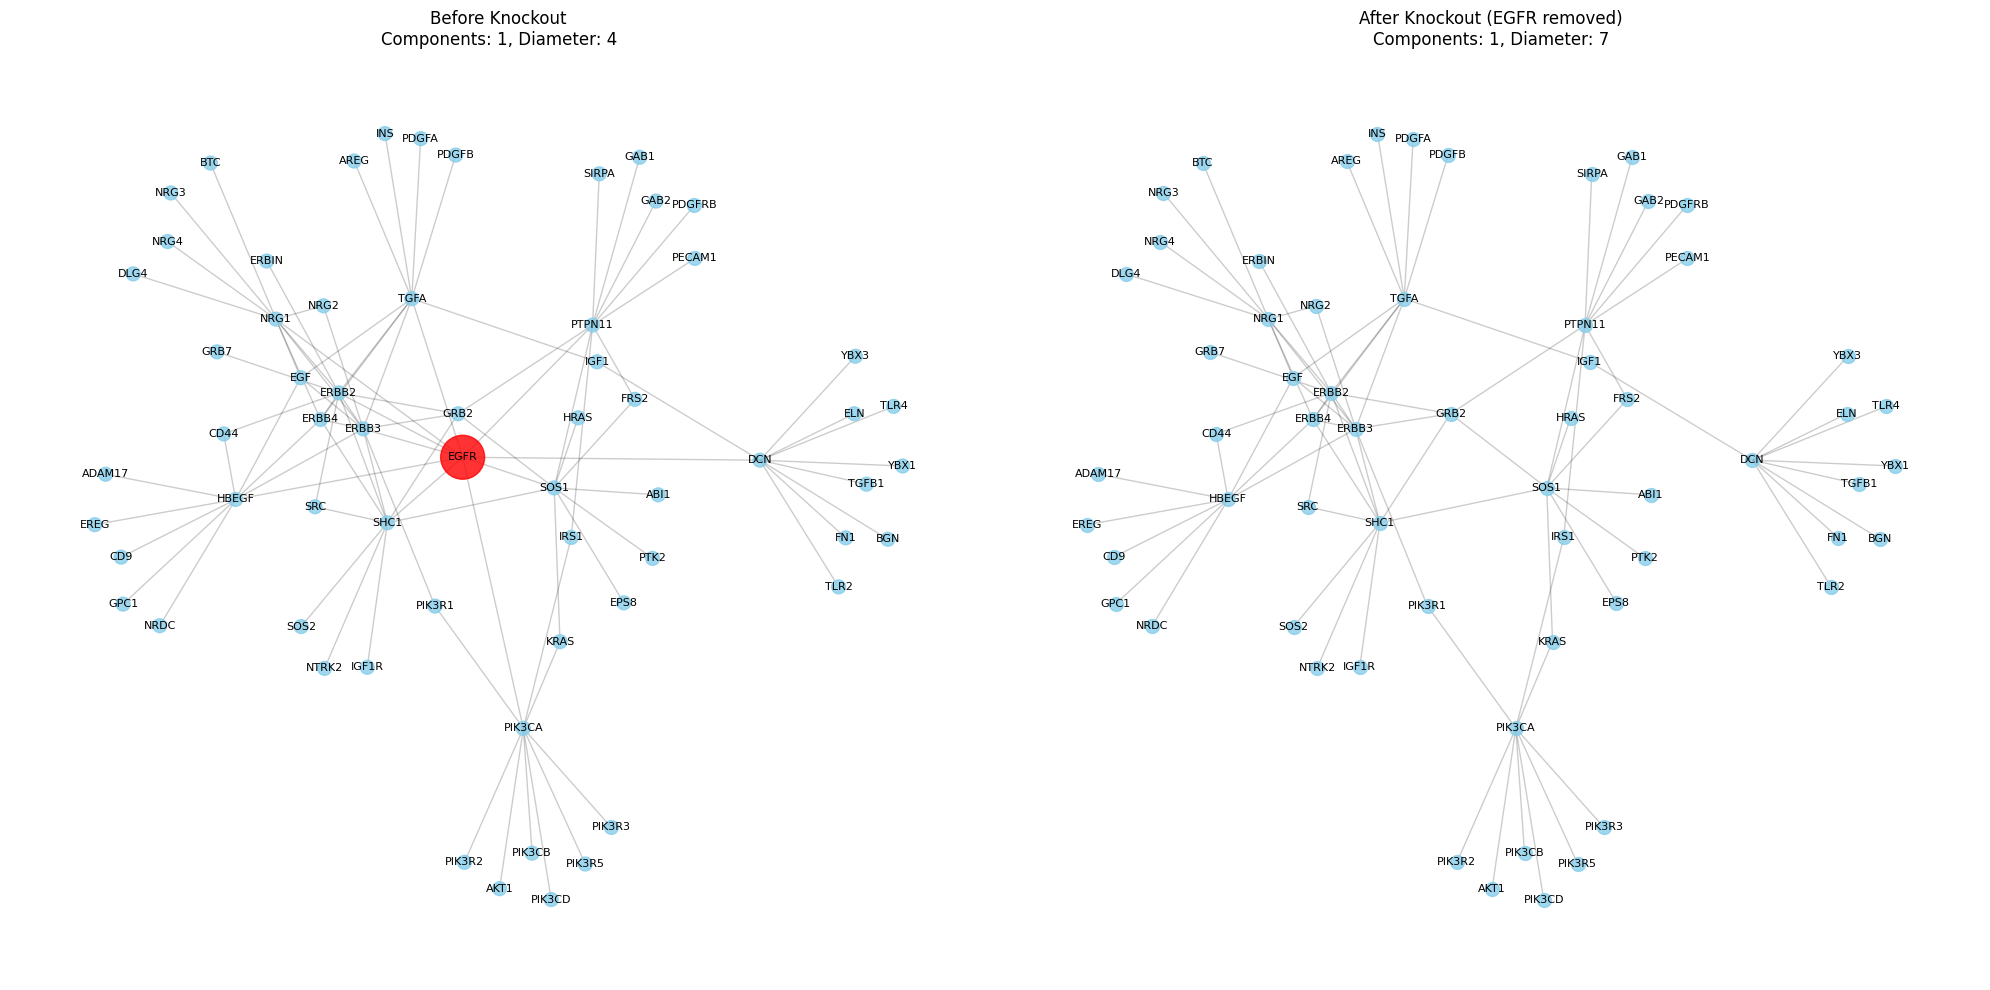

In [54]:
# ============================================================
# Step 5 — Simulate knockout of the protein
# ============================================================

print(f"Simulating knockout of {gene_symbol}...")

# Metrics before
components_before = nx.number_connected_components(G)
diameter_before = nx.diameter(G)

print(f"Before: Components={components_before}, Diameter (largest comp)={diameter_before}")

# Knockout
G_ko = G.copy()
if gene_symbol in G_ko:
    G_ko.remove_node(gene_symbol)

# Metrics after
components_after = nx.number_connected_components(G_ko)
if nx.is_connected(G_ko):
    diameter_after = nx.diameter(G_ko)
else:
    if len(G_ko) > 0:
        largest_cc_ko = max(nx.connected_components(G_ko), key=len)
        subgraph_ko = G_ko.subgraph(largest_cc_ko)
        diameter_after = nx.diameter(subgraph_ko)
    else:
        diameter_after = 0

print(f"After:  Components={components_after}, Diameter (largest comp)={diameter_after}")


degree_cent_ko = nx.degree_centrality(G_ko)
betweenness_cent_ko = nx.betweenness_centrality(G_ko)
closeness_cent_ko = nx.closeness_centrality(G_ko)

df_cent_ko = pd.DataFrame({
    'Degree_KO': degree_cent_ko,
    'Betweenness_KO': betweenness_cent_ko,
    'Closeness_KO': closeness_cent_ko
})

print("\n--- Centrality Changes (Top 10 by Degree before KO) ---")
top_nodes_before = df_cent.sort_values('Degree', ascending=False).head(15).index
top_nodes_before = [n for n in top_nodes_before if n != gene_symbol]

comparison = df_cent.loc[top_nodes_before[:10], ['Degree']].join(df_cent_ko[['Degree_KO']])
comparison['Change'] = comparison['Degree_KO'] - comparison['Degree']
print(comparison)

print("\nTop 5 New Hubs (Degree) After Knockout:")
print(df_cent_ko.sort_values('Degree_KO', ascending=False).head(5))

# Visual comparison of 2 graphs

fig, axes = plt.subplots(1, 2, figsize=(20, 10))


pos = nx.spring_layout(G, seed=42) 

node_colors = ['red' if n == gene_symbol else 'skyblue' for n in G.nodes()]
node_sizes = [1000 if n == gene_symbol else 100 for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G, pos, alpha=0.2, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=8, ax=axes[0])
axes[0].set_title(f"Before Knockout\nComponents: {components_before}, Diameter: {diameter_before}")
axes[0].axis('off')


pos_ko = {n: p for n, p in pos.items() if n in G_ko}

nx.draw_networkx_nodes(G_ko, pos_ko, node_size=100, node_color='skyblue', alpha=0.8, ax=axes[1])
nx.draw_networkx_edges(G_ko, pos_ko, alpha=0.2, ax=axes[1])
nx.draw_networkx_labels(G_ko, pos_ko, font_size=8, ax=axes[1])
axes[1].set_title(f"After Knockout ({gene_symbol} removed)\nComponents: {components_after}, Diameter: {diameter_after}")
axes[1].axis('off')

plt.tight_layout()
plt.show()